# Lecture 4 - Linear Mixed-Effects Models

## Today's Learning Goals

By the end of this lecture, you should be able to:

- Identify the model assumptions in a linear Mixed-Effects model.
- Associate a term (or combination of terms) in a Mixed-Effects model with the following quantities:

    - Fixed effect estimates.
    - Variances of the random effects.
    - Regression coefficients for each group and population.
    - Predictions on existing groups and a new group.

- Fit a linear Mixed-Effects model in `R`, and extract estimates of the above quantities.
- Identify the consequences of fitting a fixed-effects linear regression model when there are groups, whether a slope parameter is pooled or fit separately per group.
- Explain the difference between the distributional assumption on the random effects and the fixed effects estimates' sampling distribution.

## Loading Libraries

In [1]:
options(repr.matrix.max.rows = 6)
library(AER)
library(tidyverse)
library(broom)
library(nlme)
library(lme4)
library(lmerTest)

Loading required package: car



Loading required package: carData



Loading required package: lmtest



Loading required package: zoo




Attaching package: ‘zoo’




The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Loading required package: sandwich



Loading required package: survival



── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::recode() masks car::recode()
✖ purrr::some()   masks car::some()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘nlme’




The following object is masked from ‘package:dplyr’:

    collapse




Loading required package: Matrix




Attaching package: ‘Matrix’




The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack





Attaching package: ‘lme4’




The following object is masked from ‘package:nlme’:

    lmList





Attaching package: ‘lmerTest’




The following object is masked from ‘package:lme4’:

    lmer




The following object is masked from ‘package:stats’:

    step




## 1. Linear Fixed-Effects Model

So far, we have been working with regression models fitted with a **training set** of $n$ **independent elements**. 

Let us start with different modelling techniques from the ones you learned in **DSCI 561**. **Under a frequentist and classical Ordinary Least-squares (OLS) paradigm**, given a set of $k$ regressors $X_{i,j}$ and a continuous response $Y_i$, we fit a model

$$Y_i = \beta_0 + \beta_1 X_{i,1} + \beta_2 X_{i,2} + \ldots + \beta_k X_{i,k} + \varepsilon_{i} \; \; \; \; \text{for} \; i = 1, \ldots, n.$$

Note parameters $\beta_0, \beta_1, \dots, \beta_k$ are **fixed** and **constant** for **all the observed values** $\left(x_{i,1}, \dots, x_{i,k}, y_i\right)$.

```{admonition} Definition of Fixed Effects
:class: tip
OLS parameters $\beta_0, \beta_1, \dots, \beta_k$ are called **fixed effects** in Regression Analysis. In an inferential framework, it is our interest to evaluate whether they are statistically significant for the response.
```

To illustrate today's topic, let us introduce a suitable dataset.

### 1.1. Grunfeld's Investment Dataset

Consider the following example: **to study how gross investment depends on the firm's value and capital stock, [Grunfeld (1958)](https://www.proquest.com/docview/301899386?pq-origsite=summon&accountid=14656) collected data from eleven different American companies over the years 1935-1954.**

```{admonition} The Grunfeld's Investment  Dataset
The data frame `Grunfeld`, from package `AER`, contains 220 observations from a balanced panel of 11 **sampled American firms** from 1935 to 1954 (20 observations per `firm`). The dataset includes a continuous response `investment` subject to two explanatory variables, `market_value` and `capital`.
 ```

```{admonition} Definition of Balanced Panel
:class: tip
In statistical jargon, a **panel** refers to a dataset in which each **individual** (e.g., a firm) is observed within a timeframe. Furthermore, the term **balanced** indicates that we have the same number of observations per individual.
```

Firstly, we will load the data which has the following variables:

- `investment`: the gross investment in millions of American dollars (additions to plant and equipment along with maintenance), **a continuous response**.
- `market_value`: the firm's market value in millions of American dollars, **a continuous explanatory variable**.
- `capital`: stock of plant and equipment in millions of American dollars, **a continuous explanatory variable**.
- `firm`: **a nominal explanatory variable** with eleven levels indicating the firm (`General Motors`, `US Steel`, `General Electric`, `Chrysler`, `Atlantic Refining`, `IBM`, `Union Oil`, `Westinghouse`, `Goodyear`, `Diamond Match`, and `American Steel`).
- `year`: the year of the observation (*it will not be used in our analysis, but take it into account for our next in-class question*).

The code below only renames some columns from the original dataset.

In [2]:
data(Grunfeld)
Grunfeld <- Grunfeld |> 
  rename(investment = invest, market_value = value)
Grunfeld

,investment,market_value,capital,firm,year
,<dbl>,<dbl>,<dbl>,<fct>,<int>
1,317.6,3078.5,2.8,General Motors,1935
2,391.8,4661.7,52.6,General Motors,1936
3,410.6,5387.1,156.9,General Motors,1937
⋮,⋮,⋮,⋮,⋮,⋮
218,7.329,57.616,78.631,American Steel,1952
219,9.020,57.441,80.215,American Steel,1953
220,6.281,47.165,83.788,American Steel,1954


We will start with an in-class question via [**iClicker**](https://student.iclicker.com/).

```{exercise}
:label: lecture4-q1

What class of **data hierarchy** do you observe in this dataset? Do you expect any class of **correlation** within the data points?

**A.** Yes, we have a data hierarchy with one level: `firm`. Still, there will not be a correlation among subsets of data points.

**B.** Yes, we have a data hierarchy with one level: `firm`. Hence, there will be a correlation among subsets of data points.

**C.** There is no data hierarchy at all. All observations in the training set are independent.

**D.** Yes, we have a data hierarchy with two levels: `firm` (**level 1**) and the corresponding yearly observations (**level 2**). Hence, there will be a correlation among subsets of data points.
```

```{admonition} Main Statistical Inquiries
We are interested in assessing the association of gross `investment` with `market_value` and `capital` **in the population of American firms**. Then, how can we fit a linear model to this data?
```

### 1.2. Exploratory Data Analysis

Let us plot the $n = 220$ data points of `investment` versus `market_value` and `capital` but **facetted** by `firm` and use `geom_smooth()` to fit sub-models by `firm`.

```{important}
**Only for plotting**, we will transform both $x$ and $y$-axes on the logarithmic scale in base 10 (`trans = "log10"`). This allows us to compare those firms under dissimilar market values, capital, and gross investments.
```

In [3]:
scatterplots_firm_market_value <- Grunfeld |>
  ggplot(aes(market_value, investment)) +
  geom_point() +
  geom_smooth(method = "lm", fullrange = TRUE, formula = y ~ x, se = FALSE) +
  facet_wrap(~firm) +
  labs(x = "Market Value (Millions of American Dollars on a Log Scale in Base 10)", 
       y = "Gross Investment (Millions of American Dollars on a Log Scale in Base 10)") +
  ggtitle("Scatterplots by Firm of Market Value versus Gross Investments") +
  theme(
    plot.title = element_text(size = 19, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 18),
    strip.text.x = element_text(size = 18),
  ) +
  scale_x_continuous(trans = "log10") +
  scale_y_continuous(trans = "log10")

scatterplots_firm_capital <- Grunfeld |>
  ggplot(aes(capital, investment)) +
  geom_point() +
  geom_smooth(method = "lm", fullrange = TRUE, formula = y ~ x, se = FALSE) +
  facet_wrap(~firm) +
  labs(x = "Capital (Millions of American Dollars on a Log Scale in Base 10)", 
       y = "Gross Investment (Millions of American Dollars on a Log Scale in Base 10)") +
  ggtitle("Scatterplots by Firm of Capital versus Gross Investments") +
  theme(
    plot.title = element_text(size = 19, face = "bold"),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 18),
    strip.text.x = element_text(size = 18),
  ) +
  scale_x_continuous(trans = "log10") +
  scale_y_continuous(trans = "log10")

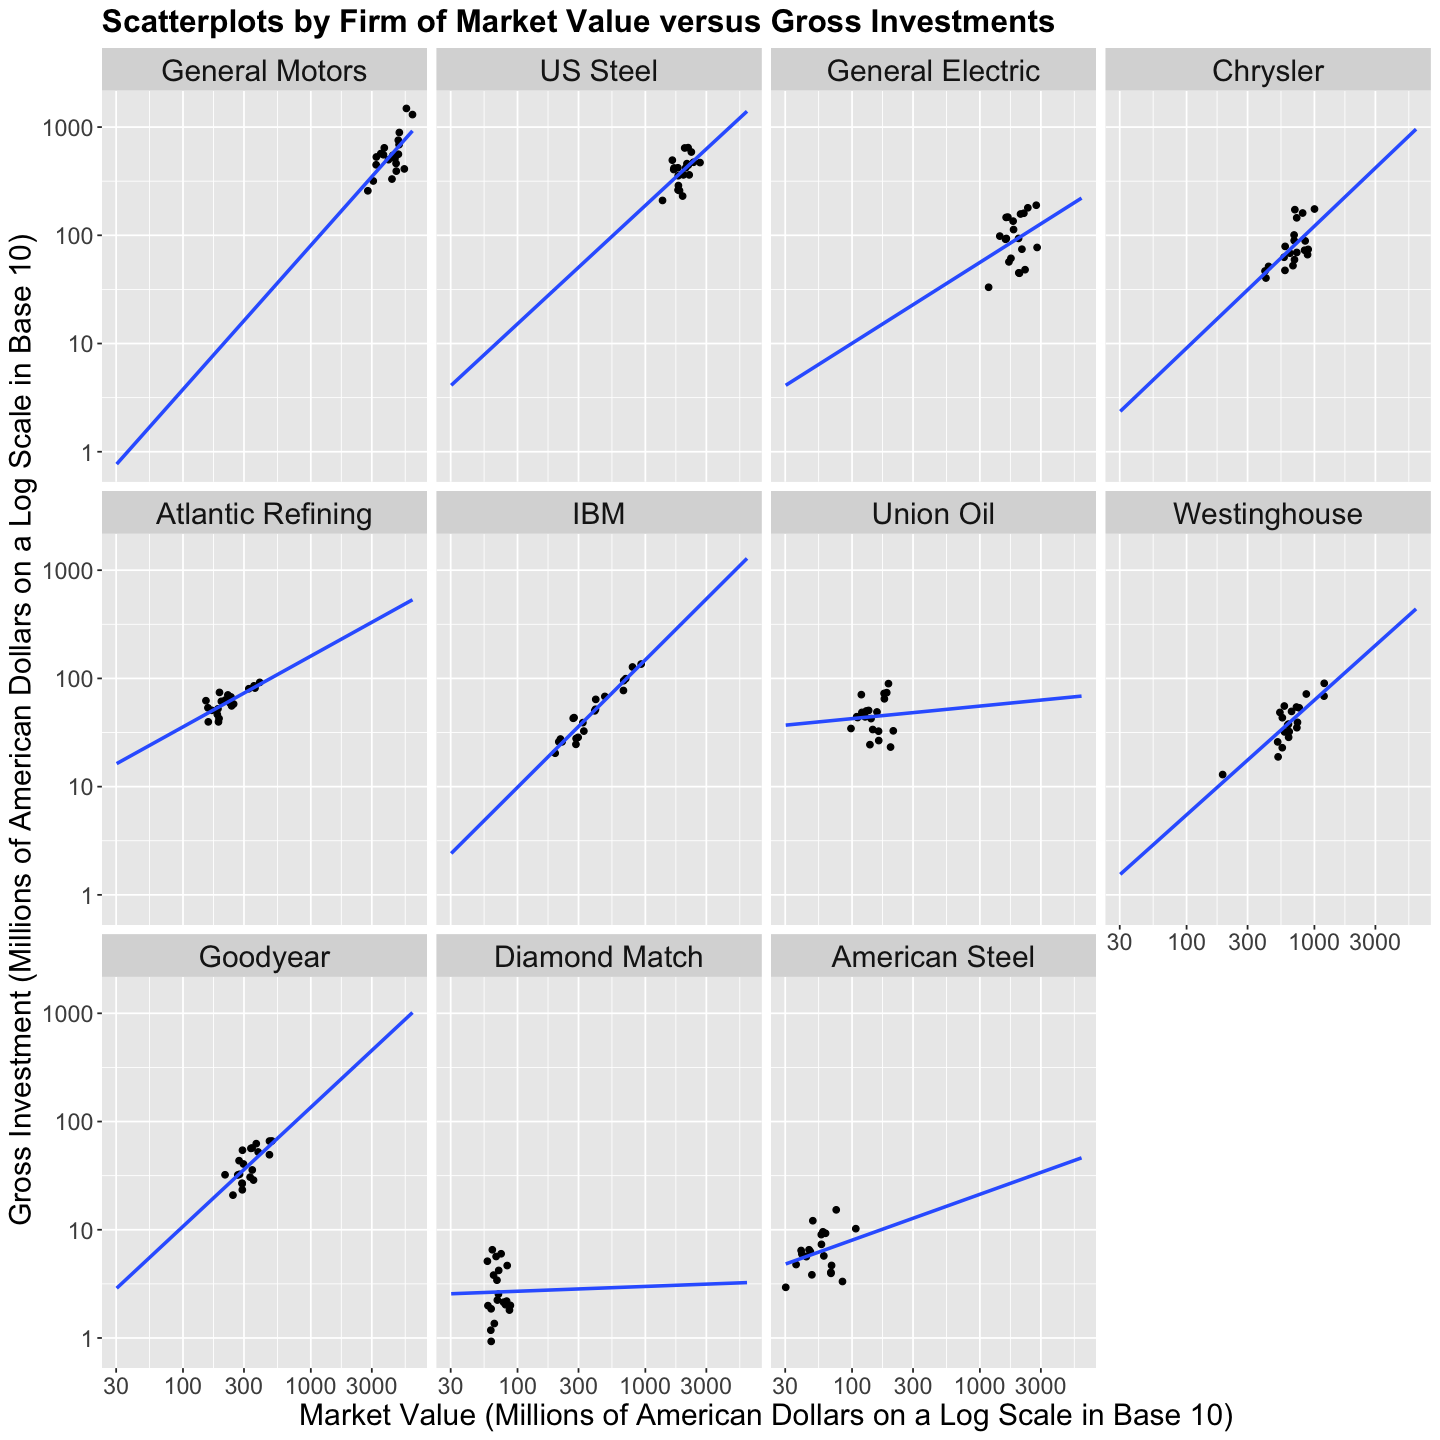

In [4]:
options(repr.plot.height = 12, repr.plot.width = 12)

scatterplots_firm_market_value

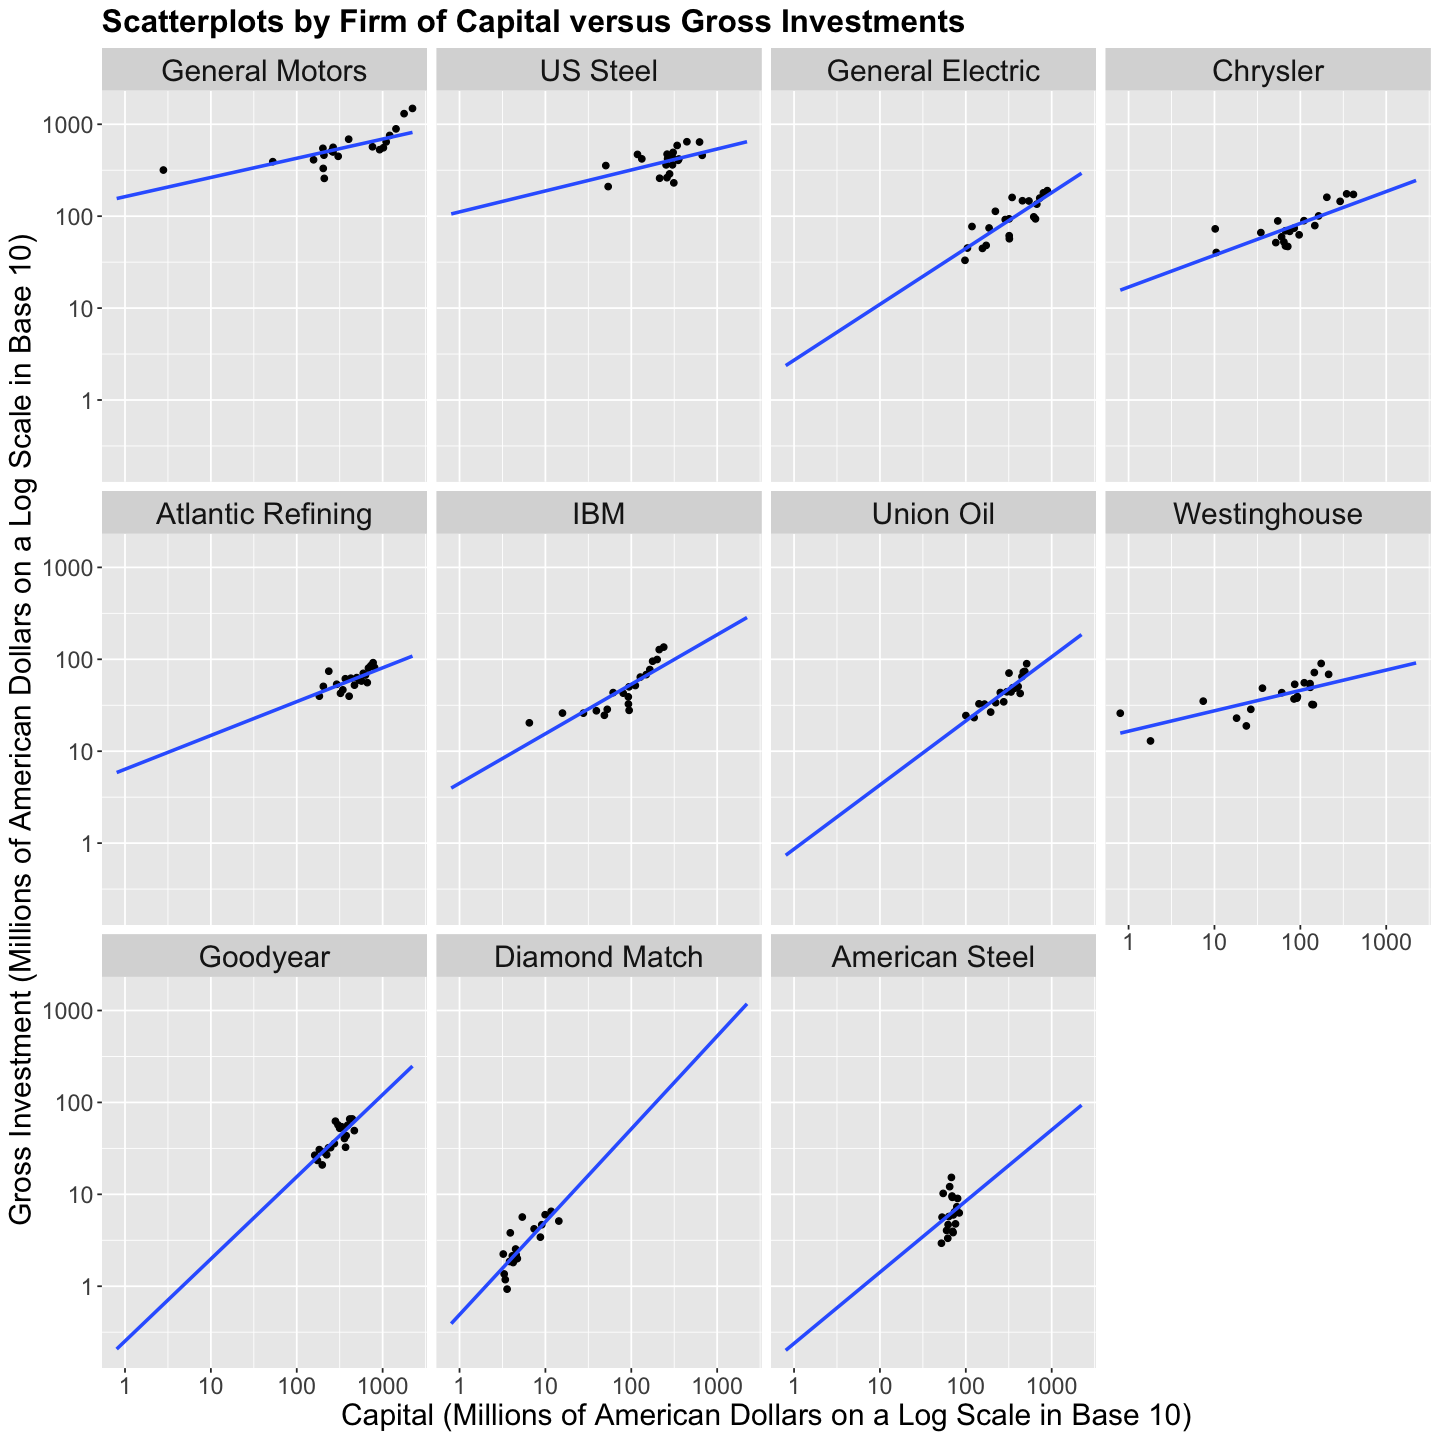

In [5]:
scatterplots_firm_capital

```{exercise}
:label: lecture4-q2

What do you observe in the plots above?
```

### 1.3. OLS Modelling Framework

Before digging into today's new modelling approach, let us try a classical approach via OLS for comparative purposes.

```{important}
**Always** keep in mind the main statistical inquiry when taking any given modelling approach.
```

#### 1.3.1. Regression Alternatives

Based on what you have seen via OLS in **DSCI 561**, there might be four possible approaches:

- Take the average for each `firm`, and fit an OLS regression on the averages. **This is not an ideal approach**, since we would lose valuable data points if we summarize them using a summary statistic of central tendency such as the average. Recall the frequentist paradigm: the more data points, the better! Therefore, **we will not use this approach in this lecture**.
- **We could ignore `firm`**, and fit an OLS regression with the other columns in the training set. Nonetheless, **this is not an ideal approach** since we will not be properly defining the corresponding systematic component of our population of interest: American firms.
- **Allow different intercepts for each `firm`.** This might be an approach worth taking using OLS modelling techniques.
- **Allow a different slope and intercept for each `firm`** (i.e., and **interaction model**!). This might be an approach worth taking using OLS modelling techniques.

#### 1.3.2. OLS Ignoring Firm

Let us start with this basic OLS model to warm up our modelling skills regarding setting up equations. Suppose we ignore factor `firm`. Then, we will estimate an OLS regression with `investment` as a response to `market_value` and `capital` as regressors.

The regression equation for the $i$th sampled observation will be:

$$\texttt{investment}_{i} = \beta_0 + \beta_1 \texttt{marketValue}_{i} + \beta_2\texttt{capital}_{i} + \varepsilon_{i} \; \; \; \; \; \text{for} \; i = 1, \ldots, 220.$$

We use `lm()` and `glance()` to get the corresponding outputs.

In [6]:
ordinary_model <- lm(formula = investment ~ market_value + capital, data = Grunfeld)
tidy(ordinary_model) |>
  mutate_if(is.numeric, round, 4)
glance(ordinary_model) |>
  mutate_if(is.numeric, round, 4)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-38.4101,8.4134,-4.5654,0
market_value,0.1145,0.0055,20.7534,0
capital,0.2275,0.0242,9.3904,0


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.8179,0.8162,90.2806,487.284,0,2,-1301.299,2610.598,2624.173,1768678,217,220


With $\alpha = 0.05$, we have evidence to state see that `market_value` and `capital` are statistically associated to `investment` since the $p\text{-values} < .001$.

#### 1.3.3. OLS Regression with Varying Intercept

Now, let us estimate another OLS regression model with `investment` as a response to `market_value` and `capital` as regressors **but with varying intercepts by each `firm`**.

We will do this with the `lm()` function by adding `- 1` on the right-hand side of the argument `formula`. This `- 1` will allow the baseline `firm` to have its intercept (i.e., renaming `(Intercept)` in column `estimate` with `firmCompanyName`). In this case, `General Motors` is the **baseline** (**it appears on the left-had side of the `levels()` output**).

In [7]:
levels(Grunfeld$firm)

[1] "General Motors"    "US Steel"          "General Electric" 
 [4] "Chrysler"          "Atlantic Refining" "IBM"              
 [7] "Union Oil"         "Westinghouse"      "Goodyear"         
[10] "Diamond Match"     "American Steel"

In [8]:
options(repr.matrix.max.rows = 33)

model_varying_intercept <- lm(formula = investment ~ market_value + capital + firm - 1, data = Grunfeld)
tidy(model_varying_intercept) |>
  mutate_if(is.numeric, round, 4)
glance(model_varying_intercept) |>
  mutate_if(is.numeric, round, 4) 

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
market_value,0.1101,0.0113,9.7461,0.0000
capital,0.3100,0.0165,18.7439,0.0000
firmGeneral Motors,-70.2991,47.3754,-1.4839,0.1394
firmUS Steel,101.9047,23.7687,4.2873,0.0000
firmGeneral Electric,-235.5694,23.2861,-10.1163,0.0000
firmChrysler,-27.8091,13.4186,-2.0724,0.0395
firmAtlantic Refining,-114.6025,13.5025,-8.4875,0.0000
firmIBM,-23.1602,12.0759,-1.9179,0.0565
firmUnion Oil,-66.5442,12.2420,-5.4357,0.0000


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.9616,0.9591,50.2995,398.2336,0,13,-1167.426,2362.851,2410.362,523718.7,207,220


By checking the `adj.r.squared`, we see that `model_varying_intercept` has a larger value (0.96) than `ordinary_model` (0.82) (i.e., the first fitted model without `firm` as a regressor). **This indicates that a model with estimated intercepts by firm fits the data better than a model without taking `firm` into account (at least by looking at the metrics!).**

Note that `model_varying_intercept` is equivalent to just fitting the OLS model using `formula = investment ~ market_value + capital + firm`. However, in this `primary_OLS`, `General Motors` estimated intercept would be called `(Intercept)` whereas the remaining ten firms will have their corresponding estimated intercepts as `(Intercept) + firmCompany` as in the `primary_OLS`. Moreover, the regression parameter estimates for `market_value` and `capital` (along with their corresponding standard errors, test statistics, and $p\text{-values}$) stay the same.

```{caution}
Even though the intercept estimates by `firm` can be easily computed using column `estimate` from `primary_OLS`; standard errors, test statistics, and $p\text{-values}$ will be different given the model parametrization in the regression equation.
```

In [9]:
primary_OLS <- lm(investment ~ market_value + capital + firm , data = Grunfeld)
tidy(primary_OLS) |>
  mutate_if(is.numeric, round, 4) 

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-70.2991,47.3754,-1.4839,0.1394
market_value,0.1101,0.0113,9.7461,0.0000
capital,0.3100,0.0165,18.7439,0.0000
firmUS Steel,172.2038,29.7001,5.7981,0.0000
firmGeneral Electric,-165.2703,30.2853,-5.4571,0.0000
firmChrysler,42.4900,41.8499,1.0153,0.3112
firmAtlantic Refining,-44.3034,48.1222,-0.9206,0.3583
firmIBM,47.1389,44.6144,1.0566,0.2919
firmUnion Oil,3.7548,48.1918,0.0779,0.9380


Going back to `model_varying_intercept` and `ordinary_model`, we can test if there is a gain in considering a varying intercept versus fixed intercept. Hence, we will make a formal **$F$-test]** to check whether the `model_varying_intercept` fits the data better than the `ordinary_model`.

In [10]:
anova(ordinary_model, model_varying_intercept) |>
  mutate_if(is.numeric, round, 4) 

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,217,1768678.4,NA,NA,NA,NA
2,207,523718.7,10,1244960,49.2071,0


We obtain a $p\text{-value} < .001$. Thus, with $\alpha = 0.05$, we have evidence to conclude that `model_varying_intercept` fits the data better than the `ordinary_model`.

However, this costs us one extra degree of freedom per `firm` **except for the baseline**. Therefore, we lose another 10 **degrees of freedom** (column `DF` in the `anova()` output).

```{important}
In this case, losing 10 degrees of freedom is not a big deal with 220 data points. Nonetheless, in other cases, when data is scarce, this could be an issue regarding inferential inquiries since we need them to perform the corresponding hypothesis testing.
```

````{exercise}
:label: lecture4-q3

What is the **sample's regression equation** for `model_varying_intercept`?

**A.**

```{math}
\begin{align*}
\texttt{investment}_{i,j} &= \beta_{0} + \beta_1 \texttt{marketValue}_{i,j} + \beta_2\texttt{capital}_{i,j} + \varepsilon_{i,j} \\
& \qquad \qquad \quad \text{for} \; i = 1, \ldots, 20 \; \; \text{and} \; \; j = 1, \ldots, 11.
\end{align*}
```

**B.**

```{math}
\begin{align*}
\texttt{investment}_{i} &= \beta_{0} + \beta_1 \texttt{marketValue}_{i} + \beta_2\texttt{capital}_{i} + \varepsilon_{i} \\
& \qquad \qquad \quad \text{for} \; i = 1, \ldots, 220.
\end{align*}
```

**C.**

```{math}
\begin{align*}
\texttt{investment}_{i,j} &= \beta_{0,j} + \beta_1 \texttt{marketValue}_{i,j} + \beta_2\texttt{capital}_{i,j} + \varepsilon_{i,j} \\
& \qquad \qquad \quad \text{for} \; i = 1, \ldots, 20 \; \; \text{and} \; \; j = 1, \ldots, 11.
\end{align*}
```
````

#### 1.3.4. OLS Regression for Each Firm

We can make the model more complex **with two interactions** (`market_value * firm` and `capital * firm`). **This will estimate a linear regression by `firm` with its own slopes.**

In [11]:
model_by_firm <- lm(investment ~ market_value * firm + capital * firm, data = Grunfeld)
tidy(model_by_firm) |>
  mutate_if(is.numeric, round, 2)
glance(model_by_firm) |>
  mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-149.78,48.07,-3.12,0.00
market_value,0.12,0.01,10.17,0.00
firmUS Steel,100.58,80.04,1.26,0.21
firmGeneral Electric,139.83,67.16,2.08,0.04
firmChrysler,143.59,64.09,2.24,0.03
firmAtlantic Refining,172.49,57.52,3.00,0.00
firmIBM,141.10,53.48,2.64,0.01
firmUnion Oil,145.28,69.34,2.10,0.04
firmWestinghouse,149.27,58.14,2.57,0.01


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.97,0.96,41.68,168.84,0,32,-1114.91,2297.81,2413.2,324895.6,187,220


In this case, we are fitting eleven linear regressions, each with 20 points.

```{important}
We have plenty of data points in this case for all the degrees of freedom required to estimate each parameter. Nonetheless, this might not be the case with other datasets.
```

````{exercise}
:label: lecture4-q4

What is the sample's regression equation for `model_by_firm`?

**A.**

```{math}
\begin{align*}
\texttt{investment}_{i,j} &= \beta_{0,j} + \beta_{1,j} \texttt{marketValue}_{i,j} + \beta_{2,j} \texttt{capital}_{i,j} + \varepsilon_{i,j} \\
& \qquad \qquad \quad \text{for} \; i = 1, \ldots, 20 \; \; \text{and} \; \; j = 1, \ldots, 11.
\end{align*}
```

**B.**

```{math}
\begin{align*}
\texttt{investment}_{j} &= \beta_{0} + \beta_1 \texttt{marketValue}_{j} + \beta_2\texttt{capital}_{j} + \varepsilon_{j} \\
& \qquad \qquad \quad \text{for} \; j = 1, \ldots, 11.
\end{align*}
```

**C.**
```{math}
\begin{align*}
\texttt{investment}_{i,j} &= \beta_{0,i} + \beta_{1,i} \texttt{marketValue}_{i,j} + \beta_{2,i} \texttt{capital}_{i,j} + \varepsilon_{i,j} \\
& \qquad \qquad \quad \text{for} \; i = 1, \ldots, 20 \; \; \text{and} \; \; j = 1, \ldots, 11.
\end{align*}
```
````

We went as far as fitting a **separate linear regression for each `firm`**. 

**How to interpret the coefficients in this `model_by_firm`?**

> Each regression coefficient is associated with a `firm`. For example, $\texttt{firmUS Steel:capital} = 0.02$ means that the variable `capital` has a slope of $0.02 + 0.37 = 0.39$ for `US Steel`. We can double-check this by estimating an individual linear regression for `US Steel`:

In [12]:
tidy(lm(investment ~ market_value + capital,
  data = Grunfeld |> filter(firm == "US Steel")
)) |>
  mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-49.20,148.08,-0.33,0.74
market_value,0.17,0.07,2.36,0.03
capital,0.39,0.14,2.74,0.01


```{exercise}
:label: lecture4-q5

Now, after all these OLS modelling approaches, are we in line with the main modelling objective with all these linear regression models?
```

``` {figure} ../img/panda.png
:height: 350px
:name: panda-2
The Questioning Panda, again!
```

## 2. Linear Mixed-Effects Model

The fact that we have **a sample of 11 companies** and our inquiry aims to make inference on the **population** of American companies, along with the correlated data structure in this **panel**, paves the way to linear Mixed-Effects modelling.

```{important}
In linear Mixed-Effects modelling, the $n$ rows in our training set will not be independent anymore. Let us view it this way: possibly, your data subsets of elements share a **correlation structure** (e.g., observations over time on a given response and regressors for a specific subject in a panel). **This is a fundamental idea in Mixed-Effects regression.**
```

Let us take a step back and think about a population of companies. For instance, all American companies. Grunfeld did not collect data on all the American companies but sampled 11 companies from this population. The author was interested in assessing whether `market_value` and `capital` were related to `investment` and by how much.

Let us assume that the $j$th sampled `firm` has its own intercept $b_{0,j}$ and the **overall fixed intercept** is $\beta_0$ **for all American companies**. Therefore, for the $j$th firm, we define the following **mixed** intercept:

$$
\beta_{0,j} = \beta_0 + b_{0,j}.
$$

The intercept $b_{0,j}$ is specifically for the $j$th `firm` that was sampled. It will change due to chance since it is linked to the $j$th sampled `firm` which would make it a **random effect**. This is the deviation of the $j$th `firm` from the overall fixed intercept $\beta_0$.

The **regression paradigm** of estimating a fixed unknown intercept $\beta_0$ will change now. Moreover, the intercept $\beta_{0,j}$ is what we call a **mixed effect**:

```{math}
\begin{align*}
\texttt{investment}_{i,j} &= \overbrace{\beta_{0,j}}^{\text{Mixed Effect}} + \beta_1 \texttt{marketValue}_{i,j} + \beta_2\texttt{capital}_{i,j} + \varepsilon_{i,j} \\
&=  (\beta_0 + b_{0,j}) + \beta_1 \texttt{marketValue}_{i,j} + \beta_2\texttt{capital}_{i,j} + \varepsilon_{i,j} \\ & \qquad \qquad \qquad \; \; \; \; \text{for} \; i = 1, \ldots, n_j \; \; \text{and} \; \; j = 1, \ldots, 11.
\end{align*}
```

Note that $n_j$ is making the model even more flexible by allowing different numbers of observations $n_j$ in each $j$th firm.

Now, 

$$b_{0,j}\sim \mathcal{N}(0, \sigma_0^2)$$ 

is called a **random effect** and we assume it is independent of the error component 

$$\varepsilon_{i,j}\sim \mathcal{N}(0, \sigma^2).$$

The observations for the same `firm` (group) share the same random effect **making a correlation structure**.

The variance of the $i$th response for the $j$th `firm` will be

$$
\text{Var}(\texttt{investment}_{i,j}) = \text{Var}(b_{0,j}) + \text{Var}(\varepsilon_{i,j}) = \sigma_0^2 + \sigma^2.
$$

For the $k$th and $l$th responses, within the $j$th firm, the correlation is given by:

$$
\text{Corr}(\texttt{investment}_{k,j}, \texttt{investment}_{l,j}) = \frac{\sigma^2_0}{\sigma_0^2 + \sigma^2}.
$$

We could even go further and model random slopes, along with the existing fixed ones, as follows:

```{math}
\begin{align*}
\texttt{investment}_{i,j}
&= \overbrace{\beta_{0,j}}^{\text{Mixed Effect}} + \overbrace{\beta_{1,j}}^{\text{Mixed Effect}} \times \texttt{marketValue}_{i,j} + \overbrace{\beta_{2,j}}^{\text{Mixed Effect}} \times \texttt{capital}_{i,j} + \varepsilon_{i,j} \\
&=  (\beta_0 + b_{0,j}) + (\beta_1 + b_{1,j}) \times \texttt{marketValue}_{i,j} + (\beta_2 + b_{2,j}) \times \texttt{capital}_{i,j} + \varepsilon_{i,j} \\
& \qquad \qquad  \qquad \qquad \qquad \qquad \text{for} \; i = 1, \ldots, n_j \; \; \text{and} \; \; j = 1, \ldots, 11;
\end{align*}
```

with $(b_{0,j}, b_{1,j}, b_{2,j})^{T} \sim \mathcal{N}_3(\mathbf{0}, \mathbf{D})$, where $\mathbf{0} = (0, 0, 0)^T$ and $\mathbf{D}$ is a generic covariance matrix.

```{important}
Note that the above random effects $b_{0,j}$, $b_{1,j}$, and $b_{2,j}$ have a multivariate Gaussian (or Normal) distribution of $d = 3$. You can review further details about this distribution in the appendix {doc}`appendix-binary-multivariate-normal`.
```

### 2.1. What is this Generic Covariance Matrix $\mathbf{D}$?

This is a **standard form** in linear Mixed-Effects modelling. Hence, this matrix becomes:

```{math}
\begin{equation*}
\mathbf{D} =
\begin{bmatrix}
\sigma_{0}^2 & \rho_{01} \sigma_{0} \sigma_{1} & \rho_{02} \sigma_{0} \sigma_{2}\\
\rho_{01} \sigma_{0} \sigma_{1} & \sigma_{1}^2 & \rho_{12} \sigma_{1} \sigma_{2}\\
\rho_{02} \sigma_{0} \sigma_{2} & \rho_{12} \sigma_{1} \sigma_{2} & \sigma_{2}^2
\end{bmatrix} = \begin{bmatrix}
\sigma_{0}^2 & \sigma_{0, 1} & \sigma_{0, 2} \\
\sigma_{0, 1} & \sigma_{1}^2 & \sigma_{1,2}\\
\sigma_{0, 2} & \sigma_{1, 2}  & \sigma_{2}^2
\end{bmatrix},
\end{equation*}
```

where $\sigma_{0}^2$, $\sigma_{1}^2$, and $\sigma_{2}^2$ are the variances of $b_{0,j}$, $b_{1,j}$, and $b_{2,j}$ respectively. 

Moreover $\rho_{uv} \in [0,1]$ is the correlation between the $u$th and the $v$th random effects. We can reexpress the covariances as $\sigma_{u, v}$.

```{important}
- $\rho_{uv}$ indicates a Pearson correlation, which you can also review [**here**](https://ubc-mds.github.io/DSCI_551_stat-prob-dsci/notes/appendix-prob-cheatsheet.html#pearson-s-correlation).
- While the **random effects are assumed to follow a mulivariate Normal distribution**, this is different from the **sampling distribution** of the estimates of the fixed effects. 
- The multivariate Normal distribution explains the variability of **random** regression intercepts and coefficients. The spread does not change when we collect more data.
- The sampling distribution explains the uncertainty in the **fixed** regression estimates and **gets narrower** as we collect more data. 
```

### 2.2. Model Fitting, Inference, and Coefficient Interpretation

Let us estimate the regression model with a mixed intercept only (`mixed_intercept_model`) via the function `lmer()` from package `lme4`. **Note that `(1 | firm)` allows the model to have a random intercept by `firm`.**

In [13]:
suppressWarnings(suppressMessages(print(mixed_intercept_model <- lmer(investment ~ market_value +
  capital + (1 | firm),
data = Grunfeld
))))

Linear mixed model fit by REML ['lmerModLmerTest']
Formula: investment ~ market_value + capital + (1 | firm)
   Data: Grunfeld
REML criterion at convergence: 2394.616
Random effects:
 Groups   Name        Std.Dev.
 firm     (Intercept) 82.10   
 Residual             50.27   
Number of obs: 220, groups:  firm, 11
Fixed Effects:
 (Intercept)  market_value       capital  
    -54.0318        0.1094        0.3082  
fit warnings:
Some predictor variables are on very different scales: consider rescaling


Recall the regression equation for `mixed_intercept_model`:

```{math}
\begin{align*}
\texttt{investment}_{i,j} &= \overbrace{\beta_{0,j}}^{\text{Mixed Effect}} + \beta_1 \texttt{marketValue}_{i,j} + \beta_2\texttt{capital}_{i,j} + \varepsilon_{i,j} \\
&=  (\beta_0 + b_{0,j}) + \beta_1 \texttt{marketValue}_{i,j} + \beta_2\texttt{capital}_{i,j} + \varepsilon_{i,j} \\ & \qquad \qquad \qquad \; \; \; \; \text{for} \; i = 1, \ldots, n_j \; \; \text{and} \; \; j = 1, \ldots, 11;
\end{align*}
```

where 

$$b_{0,j}\sim \mathcal{N}(0, \sigma_0^2)$$ 

and

$$\varepsilon_{i,j}\sim \mathcal{N}(0, \sigma^2).$$

The section `Random effects` will show the estimated standard deviations $\hat{\sigma}_0$ and $\hat{\sigma}$ as `82.10` and `50.27`, respectively. Estimated `Fixed effects` $\hat{\beta}_0$, $\hat{\beta}_1$, and $\hat{\beta}_2$ are `-54.0318`, `0.1094`, and `0.3082` respectively.

Now, let us estimate the Mixed-Effects regression model with mixed intercept and slopes (`full_mixed_model`). **Note that `(market_value + capital | firm)` allows the model to have a random intercept and slopes by `firm`.**

In [14]:
suppressWarnings(suppressMessages(print(full_mixed_model <- lmer(investment ~ market_value +
  capital + (market_value + capital | firm),
data = Grunfeld
))))

Linear mixed model fit by REML ['lmerModLmerTest']
Formula: investment ~ market_value + capital + (market_value + capital |  
    firm)
   Data: Grunfeld
REML criterion at convergence: 2299.116
Random effects:
 Groups   Name         Std.Dev. Corr       
 firm     (Intercept)  15.15612            
          market_value  0.05235 -1.00      
          capital       0.12291 -0.85  0.85
 Residual              40.77647            
Number of obs: 220, groups:  firm, 11
Fixed Effects:
 (Intercept)  market_value       capital  
    -7.79756       0.06118       0.22694  
fit warnings:
Some predictor variables are on very different scales: consider rescaling
optimizer (nloptwrap) convergence code: 0 (OK) ; 0 optimizer warnings; 1 lme4 warnings 


Recall the regression equation for `full_mixed_model`:

```{math}
\begin{align*}
\texttt{investment}_{i,j}
&= \overbrace{\beta_{0,j}}^{\text{Mixed Effect}} + \overbrace{\beta_{1,j}}^{\text{Mixed Effect}} \times \texttt{marketValue}_{i,j} + \overbrace{\beta_{2,j}}^{\text{Mixed Effect}} \times \texttt{capital}_{i,j} + \varepsilon_{i,j} \\
&=  (\beta_0 + b_{0,j}) + (\beta_1 + b_{1,j}) \times \texttt{marketValue}_{i,j} + (\beta_2 + b_{2,j}) \times \texttt{capital}_{i,j} + \varepsilon_{i,j} \\
& \qquad \qquad  \qquad \qquad \qquad \qquad \text{for} \; i = 1, \ldots, n_j \; \; \text{and} \; \; j = 1, \ldots, 11;
\end{align*}
```

with $(b_{0,j}, b_{1,j}, b_{2,j})^{T} \sim \mathcal{N}_3(\mathbf{0}, \mathbf{D})$, where $\mathbf{0} = (0, 0, 0)^T$ and $\mathbf{D}$ is a generic covariance matrix.

The section `Random effects` will show the estimated standard deviations $\hat{\sigma}_0$, $\hat{\sigma}_1$, $\hat{\sigma}_2$, and $\hat{\sigma}$ as `15.15612`, `0.05235`, `0.12291`, and `40.77647` respectively. Estimated `Fixed effects` $\hat{\beta}_0$, $\hat{\beta}_1$, and $\hat{\beta}_2$ are `-7.79756`, `0.06118`, and `0.22694` respectively.

Let us proceed with inference using  `mixed_intercept_model`. We now assess whether the fixed effects are statistically associated with `investment` in each model via `summary()`. We will use the package `lmerTest` along with function `summary()`.

In [15]:
library(lmerTest)
summary(mixed_intercept_model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: investment ~ market_value + capital + (1 | firm)
   Data: Grunfeld

REML criterion at convergence: 2394.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6018 -0.3138  0.0139  0.3148  5.0604 

Random effects:
 Groups   Name        Variance Std.Dev.
 firm     (Intercept) 6741     82.10   
 Residual             2528     50.27   
Number of obs: 220, groups:  firm, 11

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  -54.031821  26.623551  12.069048  -2.029   0.0651 .  
market_value   0.109352   0.009987 129.346325  10.950   <2e-16 ***
capital        0.308200   0.016368 213.247094  18.830   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) mrkt_v
market_valu -0.312       
capital     -0.021 -0.369
fit warnings:
Some predictor variables are on very different s

We do the same with `full_mixed_model`.

In [16]:
summary(full_mixed_model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: investment ~ market_value + capital + (market_value + capital |  
    firm)
   Data: Grunfeld

REML criterion at convergence: 2299.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5030 -0.1660  0.0100  0.1819  4.1389 

Random effects:
 Groups   Name         Variance  Std.Dev. Corr       
 firm     (Intercept)  2.297e+02 15.15612            
          market_value 2.741e-03  0.05235 -1.00      
          capital      1.511e-02  0.12291 -0.85  0.85
 Residual              1.663e+03 40.77647            
Number of obs: 220, groups:  firm, 11

Fixed effects:
             Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  -7.79756    7.79890  7.01489  -1.000 0.350626    
market_value  0.06118    0.01927  7.74466   3.175 0.013660 *  
capital       0.22694    0.04422  9.52493   5.132 0.000517 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlati

We can see that `market_value` and `capital` are significant with $\alpha = 0.05$ in both models. **Moreover, the regression coefficients' interpretation for the fixed effects will be on the effect these regressors have on the population `investment` mean of the American companies.**

We can obtain the estimated coefficients by `firm` along with the intercepts for both models via `coef()`.

In [17]:
coef(mixed_intercept_model)$firm

,(Intercept),market_value,capital
,<dbl>,<dbl>,<dbl>
General Motors,-65.526515,0.109352,0.3081997
US Steel,101.069974,0.109352,0.3081997
General Electric,-230.027388,0.109352,0.3081997
Chrysler,-27.544640,0.109352,0.3081997
Atlantic Refining,-112.435102,0.109352,0.3081997
IBM,-23.220327,0.109352,0.3081997
Union Oil,-65.632801,0.109352,0.3081997
Westinghouse,-56.815866,0.109352,0.3081997
Goodyear,-85.813152,0.109352,0.3081997


Column `(Intercept)` is the sum $\hat{\beta}_0 + \hat{b}_{0,j}$. Note the estimated regression coefficients for `market_value` and `capital` are the same since `mixed_intercept_model` only has $\beta_1$ and $\beta_2$ as its general modelling setup.

The coefficient summary changes in `full_mixed_model` given that we also include random effects for `market_value` and `capital`, as shown below. Columns `market_value` and `capital` are the sums $\hat{\beta}_1 + \hat{b}_{1,j}$ and $\hat{\beta}_2 + \hat{b}_{2,j}$, respectively. Column `(Intercept)` is the sum $\hat{\beta}_0 + \hat{b}_{0,j}$.

In [18]:
coef(full_mixed_model)$firm

,(Intercept),market_value,capital
,<dbl>,<dbl>,<dbl>
General Motors,-15.9552583,0.08936163,0.3746270
US Steel,-37.3981285,0.16343240,0.4206200
General Electric,3.7069150,0.02144198,0.1453769
Chrysler,-16.9962883,0.09295769,0.3041952
Atlantic Refining,6.5953958,0.01146421,0.1027958
IBM,-14.2108882,0.08333600,0.2855949
Union Oil,0.9675705,0.03090458,0.1371497
Westinghouse,-2.7054789,0.04359251,0.1826596
Goodyear,3.9889246,0.02046783,0.1116272


```{exercise}
:label: lecture4-q6

Note the standard errors for the estimated slopes in `market_value` and `capital` behave in a really particular way when comparing the OLS `model_varying_intercept` and the Mixed-Effects `full_mixed_model`. 

Therefore, **what are the advantages of a Mixed-Effects model over an OLS model with fixed-effects only?**
```

In [19]:
tidy(model_varying_intercept) |> 
  mutate_if(is.numeric, round, 4)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
market_value,0.1101,0.0113,9.7461,0.0000
capital,0.3100,0.0165,18.7439,0.0000
firmGeneral Motors,-70.2991,47.3754,-1.4839,0.1394
firmUS Steel,101.9047,23.7687,4.2873,0.0000
firmGeneral Electric,-235.5694,23.2861,-10.1163,0.0000
firmChrysler,-27.8091,13.4186,-2.0724,0.0395
firmAtlantic Refining,-114.6025,13.5025,-8.4875,0.0000
firmIBM,-23.1602,12.0759,-1.9179,0.0565
firmUnion Oil,-66.5442,12.2420,-5.4357,0.0000


In [20]:
summary(full_mixed_model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: investment ~ market_value + capital + (market_value + capital |  
    firm)
   Data: Grunfeld

REML criterion at convergence: 2299.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5030 -0.1660  0.0100  0.1819  4.1389 

Random effects:
 Groups   Name         Variance  Std.Dev. Corr       
 firm     (Intercept)  2.297e+02 15.15612            
          market_value 2.741e-03  0.05235 -1.00      
          capital      1.511e-02  0.12291 -0.85  0.85
 Residual              1.663e+03 40.77647            
Number of obs: 220, groups:  firm, 11

Fixed effects:
             Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  -7.79756    7.79890  7.01489  -1.000 0.350626    
market_value  0.06118    0.01927  7.74466   3.175 0.013660 *  
capital       0.22694    0.04422  9.52493   5.132 0.000517 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlati

### 2.3. Estimation

The previous section skipped the estimation phase. However, we must point out that **maximum likelihood estimation (MLE)** is **still present** in Mixed-Effects modelling. Nevertheless, MLE is performed in a different way. Recall that OLS only has a single variance component $\sigma^2$, but in Mixed-Effects modelling, we have the variance component from each random effect.

Having said that, Mixed-Effects modelling performs what we call **restricted MLE (R-MLE)**. Overall, R-MLE partions the joint likelihood of the observed data in two parts:

1. One related to the fixed effects, which yields the estimates $\hat{\beta}_0, \hat{\beta}_1, \dots, \hat{\beta}_k$ when we have $k$ regressors.
2. Another related to the variance components of the random effects and the overall variance $\sigma^2$.

Overall, this likelihood restriction will allow us to deliver unbiased estimates of the variance components in (2) because the fixed effects' contribution is isolated in (1).

### 2.4. Prediction

We can make two classes of predictions with Mixed-Effects models:

1. **To predict on an existing group**, we find that group's regression coefficients (and therefore model function) by summing the fixed effects and (if present) the random effects, then use that model function to make predictions.
2. **To predict on a new group (using a mean prediction)**, we use the fixed effects as the regression coefficients (because the random effects are assumed to have a mean equal to zero) and use that model function to make predictions. 

For **predictions on an existing group in our training set** we have:

In [21]:
round(predict(full_mixed_model, newdata = tibble(
  firm = "General Motors",
  market_value = 2000, capital = 1000
)), 2)

1 
537.4

If we wanted **to predict the `investment` for `General Motors`** with a `market_value` of USD $\$2,000$ million and capital of USD $\$1,000$ million, then our answer would be USD $\$537.4$ million. This prediction uses $\hat{\beta}_0$, $\hat{\beta}_1$, $\hat{\beta}_2$, $\hat{b}_{0, j}$, $\hat{b}_{1, j}$, and $\hat{b}_{2, j}$.

Whereas that for **predictions on American companies in general**, we have:

In [22]:
round(predict(full_mixed_model,
  newdata = tibble(
    firm = "New Company",
    market_value = 2000, capital = 1000
  ),
  allow.new.levels = TRUE
), 2)

1 
341.51

If we wanted **to predict the MEAN `investment` for American companies** with a `market_value` of USD $\$2,000$ million and capital of USD $\$1,000$ million, then our answer would be USD $\$341.51$ million. This prediction only uses $\hat{\beta}_0$, $\hat{\beta}_1$, and $\hat{\beta}_2$.

## 3. Wrapping Up on Mixed-Effects Modelling

- In many different cases, when there is a correlation structure in our observations, OLS models are not suitable for our inferential or predictive inquiries.
- Therefore, linear Mixed-Effects models are suitable for correlated observations. Nonetheless, the model's complexity will also be in function of our specific inquiries.
- We can even extend the Mixed-Effects approach to generalized linear models (GLMs)!